# Fig 2. SI: normalized slopes

Bar plots for different thresholds/metrics


To do
- check whether to do mean/median, consistent in both? - for reporting use delta method to aggregate estimates??
- Decide on aesthetics / labels etc / how to communicate also the nahd per person
- make SI figure with normalized slopes for all metrics/thresholds
- double check sample_pi.py function on a single pixel to see it's working properly, try to understand why so different reanalysis v. models? 

See old version in xxx -slopes? 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels??)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4
import matplotlib.patches as mpatches
from scipy.stats import norm
import pickle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings_ana import *

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *

# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/')) #hpc
#sys.path.append(os.path.join('dem4cli/')) #local
from population_demographics import * 

In [2]:
start_message()

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
tim

In [3]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/zen4/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37143 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37143/status,
Dashboard: http://127.0.0.1:37143/status,Workers: 1
Total threads: 1,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41625,Workers: 1
Dashboard: http://127.0.0.1:37143/status,Total threads: 1
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:46095,Total threads: 1
Dashboard: http://127.0.0.1:33515/status,Memory: 40.00 GiB
Nanny: tcp://127.0.0.1:46287,


In [4]:
figdir = os.path.join(figdirs, 'fig_sep24')


# Functions (finalize+move from here)

To do
- do median + IQR in all?
- finalise reporting fxns, check different ways of CI and aggregating/reporting result 

In [5]:
def df_summary_mean_range(da,feature,units):
    
    if units > 100:
        df_summary = da.sel(features=feature).to_pandas().T / units
    elif units == 100:
        df_summary = da.sel(features=feature).to_pandas().T * units
    elif units == None:
         df_summary = da.sel(features=feature).to_pandas().T
    df_summary['mean'] = df_summary.iloc[:,0:6].mean(axis=1)
    df_summary['min'] = df_summary.iloc[:,0:6].min(axis=1)
    df_summary['max'] = df_summary.iloc[:,0:6].max(axis=1)
    df_summary = df_summary.astype(float)
    
    return df_summary.round(decimals=1)


def df_summary_median_iqr(da,feature,units=None):
    df_summary = da.sel(features=feature).to_pandas().T
    df_summary['median'] = df_summary.iloc[:,0:6].median(axis=1)
    df_summary['Q1'] = df_summary.iloc[:,0:6].quantile(0.25,axis=1)
    df_summary['Q3'] = df_summary.iloc[:,0:6].quantile(0.75,axis=1)
    df_summary = df_summary.astype(float)

    return df_summary.round(decimals=1)
    

In [6]:
def calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2022,GWI=1.3):

    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 
    gmst_pi = float(gmst_pres - GWI)

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')


    if len(da_params.params) >3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0+sigma_b1*gmst_pi), norm(loc=b0+b1*gmst_pres, scale=sigma_b0+sigma_b1*gmst_pres)
    elif len(da_params.params) ==3:
        sigma_b0 = da_params.sel(params='sigma')
        norm_pi, norm_pres = norm(loc=b0+b1*gmst_pi, scale=sigma_b0), norm(loc=b0+b1*gmst_pres, scale=sigma_b0)

    data = norm_pres.sf(threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    data = norm_pi.sf(threshold)
    da_p0 = xr.DataArray(
        data=data,
        dims=[ "dataset", "month", "lat", "lon"],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )

    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years

    # add dimension for correct multiplication
    days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1['month']})

    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 - da_p0) * days_in_month_da
    
    da_nAHD = da_nAHD_mo.sum(dim='month')


    return da_nAHD, da_nAHD_mo, da_p0, da_p1

In [7]:
def calc_nAHD_shift_fit_percentile_from_sample(da_params, 
                                             percentile, 
                                             gmst_smo,
                                               samples_pi,
                                             year_pres=2023,
                                             GWI=1.3,
                                            #mc_samplesize=1000,
                                            ):

    gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ?? 

    b0 = da_params.sel(params='b0')
    b1 = da_params.sel(params='b1')
    
    # Get params
    if len(da_params.params) > 3:
        sigma_b0 = da_params.sel(params='sigma_b0')
        sigma_b1 = da_params.sel(params='sigma_b1')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0 + sigma_b1 * gmst_pi
        std_pres = sigma_b0 + sigma_b1 * gmst_pres
    else:
        sigma_b0 = da_params.sel(params='sigma')
        mean_pi = b0 + b1 * gmst_pi
        mean_pres = b0 + b1 * gmst_pres
        std_pi = sigma_b0
        std_pres = sigma_b0

    # theoretical distributions per month in present for later 
    norm_pres = norm(loc=mean_pres, scale=std_pres)
    

    # weights 
    coords = dict(month=("month", np.arange(1,13)))
    days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # ignoring leap years
    weights = xr.DataArray(days_in_month, dims="month", coords=coords)
    
    # weigh the sample by month length and get qth percentile value 
    da_threshold = samples_pi.weighted(weights).quantile(percentile, dim=['samples','month'])

    # expand dims
    da_threshold = da_threshold.expand_dims('month', axis=1)
    # get p of exceedance of pi 90th percentile threshold in each grid cell 
    data = norm_pres.sf(da_threshold)
    da_p1 = xr.DataArray(
        data=data,
        dims=["dataset", "month", "lat", "lon", ],
        coords=dict(
            lon=(["lon"], da_params.lon.data),
            lat=(["lat"], da_params.lat.data),
            month=da_params.month.data,
            dataset=da_params.dataset.data) )
    
    # calc nAHD per month and per year
    da_nAHD_mo = (da_p1 -  (1 - percentile)) *  weights 
    
    da_nAHD = da_nAHD_mo.sum(dim='month')

    return da_nAHD, da_nAHD_mo, da_threshold, da_p1
    

In [8]:
def get_gmst_smo(ntime=4):
    
    df_gmst_obs_annual = pd.read_csv(os.path.join(datadirs,'gmst/gmst-obs/forster2024/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
    gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=ntime))
    
    return gmst_smo

# Data prep

## 0. Population preprocessing


In [9]:
gs_population_global = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

# add message that say n of countries !

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## 1. WBGT28

### Reanalysis 


In [10]:
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join(outdirs, 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_loglike_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    
    da_params = xr.concat(da_list, dim="dataset")
    

In [11]:
gmst_smo = get_gmst_smo()

In [12]:
threshold = 28
GWI=1.3

from scipy.stats import norm

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=GWI)

/tmp/ipykernel_816887/927337717.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


In [13]:
da_nAHD = da_nAHD_obs.rename({'dataset':'model'})

da_n_people_ndays_obs, da_prop_people_ndays_obs = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

### Climate models

In [14]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 


In [15]:
da_nAHD = da_nAHD_models

da_n_people_ndays_models, da_prop_people_ndays_models = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 3. WBGT30

In [16]:
# Observations 

threshold = 30

da_nAHD_obs_30, da_nAHD_mo_30, da_p0_30, da_p1_30 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

da_nAHD = da_nAHD_obs_30.rename({'dataset':'model'})

da_n_people_ndays_obs_30, da_prop_people_ndays_obs_30 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_30 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

/tmp/ipykernel_816887/927337717.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


In [17]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_30 = open_all_nAHD(GCMs,  metric='WBGT30', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_30

da_n_people_ndays_models_30, da_prop_people_ndays_models_30 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_30 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 4. WBGT33 

(maybe don't include?)

In [18]:
threshold = 33

da_nAHD_obs_33, da_nAHD_mo_33, da_p0_33, da_p1_33 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

da_nAHD = da_nAHD_obs_33.rename({'dataset':'model'})

da_n_people_ndays_obs_33, da_prop_people_ndays_obs_33 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_33 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

/tmp/ipykernel_816887/927337717.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  gmst_pres = float(gmst_smo.loc[year_pres]) # take smoothed or not smoothed covariate ??


In [19]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_33 = open_all_nAHD(GCMs,  metric='WBGT33', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_33

da_n_people_ndays_models_33, da_prop_people_ndays_models_33 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_33 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

## 5. WBGT90,95,99 

### Models 

In [20]:
# climate models 

dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_W99 = open_all_nAHD(GCMs,  metric='WBGT99', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W99

da_n_people_ndays_models_W99, da_prop_people_ndays_models_W99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [21]:

da_nAHD_models_W90 = open_all_nAHD(GCMs,  metric='WBGT90', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W90

da_n_people_ndays_models_W90, da_prop_people_ndays_models_W90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                           mask_where_decr=False
                                                                           )

In [22]:

da_nAHD_models_W95 = open_all_nAHD(GCMs,  metric='WBGT95', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models_W95

da_n_people_ndays_models_W95, da_prop_people_ndays_models_W95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_W95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

### Obs

In [23]:
inDIR=os.path.join(outdirs,f'output_shift-fit/forster2024/WBGT/ISIMIP3a/sample_pi/GWI{str(GWI)}/')

pctl=0.9
files = [ os.path.join(inDIR,f'{VAR}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_1901_2019.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W90, da_nAHD_obs_mo_W90, da_threshold_obs_W90, da_p1_obs_W90 = [ xr.open_dataarray(f) for f in files] 

pctl=0.95
files = [ os.path.join(inDIR,f'{VAR}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_1901_2019.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W95, da_nAHD_obs_mo_W95, da_threshold_obs_W95, da_p1_obs_W95 = [ xr.open_dataarray(f) for f in files] 

pctl=0.99
files = [ os.path.join(inDIR,f'{VAR}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_1901_2019.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_W99, da_nAHD_obs_mo_W99, da_threshold_obs_W99, da_p1_obs_W99 = [ xr.open_dataarray(f) for f in files] 


In [24]:

da_nAHD = da_nAHD_obs_W99.rename({'dataset':'model'})

da_n_people_ndays_obs_W99, da_prop_people_ndays_obs_W99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [25]:

da_nAHD = da_nAHD_obs_W95.rename({'dataset':'model'})

da_n_people_ndays_obs_W95, da_prop_people_ndays_obs_W95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [26]:

da_nAHD = da_nAHD_obs_W90.rename({'dataset':'model'})

da_n_people_ndays_obs_W90, da_prop_people_ndays_obs_W90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_W90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


## 6. TX95, TX99 

### Models

In [27]:
da_nAHD_TX90_models = open_all_nAHD(GCMs,  metric='TX90', outdirname=dirname, year_pres=year) 
da_nAHD_TX95_models = open_all_nAHD(GCMs,  metric='TX95', outdirname=dirname, year_pres=year)  
da_nAHD_TX99_models = open_all_nAHD(GCMs,  metric='TX99', outdirname=dirname, year_pres=year) 

In [28]:
da_nAHD = da_nAHD_TX90_models

da_n_people_ndays_models_TX90, da_prop_people_ndays_models_TX90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [29]:
da_nAHD = da_nAHD_TX95_models

da_n_people_ndays_models_TX95, da_prop_people_ndays_models_TX95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

In [30]:
da_nAHD = da_nAHD_TX99_models

da_n_people_ndays_models_TX99, da_prop_people_ndays_models_TX99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_models_TX99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           GCMs, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )

### Obs

In [31]:
metric='TX'
inDIR=os.path.join(outdirs,f'output_shift-fit/forster2024/{metric}/ISIMIP3a/sample_pi/GWI{str(GWI)}/')

pctl=0.9
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_1901_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_TX90, da_nAHD_obs_mo_TX90, da_threshold_obs_TX90, da_p1_obs_TX90 = [ xr.open_dataarray(f) for f in files] 

pctl=0.95
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_1901_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_TX95, da_nAHD_obs_mo_TX95, da_threshold_obs_TX95, da_p1_obs_TX95 = [ xr.open_dataarray(f) for f in files] 

pctl=0.99
files = [ os.path.join(inDIR,f'{VAR}_{metric}_sample_pi_percentile_{str(pctl)}_shiftfit_loc_1901_2019_GWI{str(GWI)}.nc') \
         for VAR in ['nAHD','nAHD_mo','threshold','p1'] ] 
da_nAHD_obs_TX99, da_nAHD_obs_mo_TX99, da_threshold_obs_TX99, da_p1_obs_TX99 = [ xr.open_dataarray(f) for f in files] 


In [32]:

da_nAHD = da_nAHD_obs_TX99.rename({'dataset':'model'})

da_n_people_ndays_obs_TX99, da_prop_people_ndays_obs_TX99 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_TX99 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [33]:

da_nAHD = da_nAHD_obs_TX95.rename({'dataset':'model'})

da_n_people_ndays_obs_TX95, da_prop_people_ndays_obs_TX95 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_TX95 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


In [34]:

da_nAHD = da_nAHD_obs_TX90.rename({'dataset':'model'})

da_n_people_ndays_obs_TX90, da_prop_people_ndays_obs_TX90 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          datasets, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])



da_nAHD_percapita_peopledays_10y_obs_TX90 = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                                                           datasets, 
                                                                           da_nAHD,
                                                                           x_hot_days = [1, 5, 10, 20, 50], 
                                                                           ages_values=range(0,100),
                                                                           grouped = True,
                                                                           size_win = 10,
                                                                         mask_where_decr=False
                                                                           )


# Supplementary figure: normalized slopes

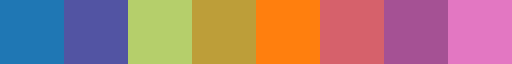

In [35]:
# colormap

original_cmap = plt.get_cmap('tab20b')
selected_colors = ['C0', original_cmap(1), 
                   original_cmap(6), original_cmap(9), 'C1', original_cmap(14), original_cmap(17), 'C6' ]
custom_cmap = ListedColormap(selected_colors)
custom_cmap

In [36]:
def plot_normalized_slopes(da, ax, legend=False, title=None, custom_ticks=None, step_ages=9, x_hot_days=[1,5,10,20,50], cmap=None):
    
    # Define a custom formatter function for the y-axis
    def fraction_formatter(x, pos):
        denominator = 1 / x
        if denominator.is_integer():
            return f'{int(round(denominator))}x'
        else:
            return f'{denominator}x'
    formatter = FuncFormatter(fraction_formatter)

    # Create the original Reds colormap
    original_cmap = plt.get_cmap(cmap)
    start = 0.3  # Starting point (20% into the colormap)
    end = 1.0    # Ending point (full colormap)
    colors = original_cmap(np.linspace(start, end, 256))
    custom_cmap = ListedColormap(colors)

    # plot
    ( da / da.sel(age_ranges=0)).astype(float).median(dim='model').to_pandas().plot(ax=ax,legend=False,marker='.', colormap=custom_cmap)

    # settings for title
    xpos=-.05
    ypos=1.05
    
    ax.set_title(title,loc='left', fontweight='bold',x=xpos,y=ypos,transform=ax.transAxes)
    ax.grid()
    ax.set_xlabel(' ')
    ax.set_xticks(ticks=np.arange(0,91,10), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges.values],  rotation=40)
    
    ax.invert_yaxis()
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yticks(custom_ticks)
    
    if legend:
        leg = ax.legend(labels = [f'$\geq${x}' for x in x_hot_days],
                  title='Days per year',
                 handlelength=1.2,handletextpad=0.4,labelspacing = .1,
                 bbox_to_anchor=(0, 1.04),
                  loc='upper left')
        leg._legend_box.align = "left"
        leg.get_frame().set_linewidth(0.0)



    

In [37]:
def plot_normalized_slopes_percap(das, ax, title=None, custom_ticks=None, step_ages=9, labels=None,cmap=None):

    # Define a custom formatter function for the y-axis
    def fraction_formatter(x, pos):
        denominator = 1 / x
        if denominator.is_integer():
            return f'{int(round(denominator))}x'
        else:
            return f'{denominator}x'
    formatter = FuncFormatter(fraction_formatter)

    # colors 
    colmap = plt.get_cmap(cmap)
    colors = iter(colmap.colors)  


    # plot 
    for da, label in zip(das, labels):
        da=da.sel(features='per_capita_days')
        ( da / da.sel(age_ranges=0)).mean(dim='model').to_pandas().plot(ax=ax,label=label,marker='.', c=next(colors))


    # settings for title
    xpos=-.05
    ypos=1.07

    # title, labels etc 
    ax.set_title(title,loc='left',fontweight='bold',x=xpos,y=ypos,transform=ax.transAxes)
    ax.grid()
    ax.set_xlabel(' ')
    ax.set_xticks(ticks=np.arange(0,91,10), labels=[f'{x}-{x+step_ages}' for x in da.age_ranges.values],  rotation=40);
    ax.set_xlabel('Ages')

    # yaxis 
    ax.invert_yaxis()
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yticks(custom_ticks)

    # legend
    leg = ax.legend(fontsize=8.5, bbox_to_anchor=(0, 1.15), loc='upper left')
    leg.get_frame().set_linewidth(0.0)
    #ax.legend(bbox_to_anchor=(1, 1))
        


## Plot

### GCM

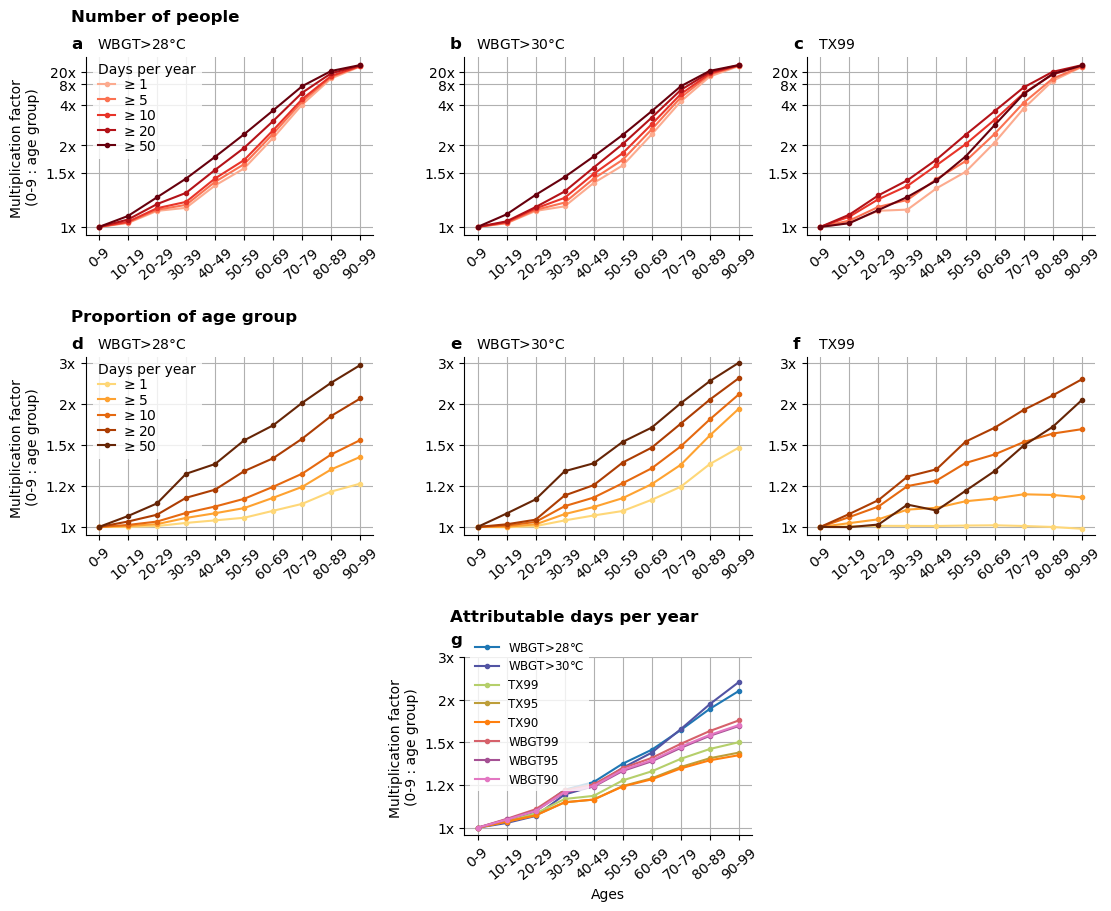

In [69]:

fig = plt.figure(figsize=(11, 9), layout='constrained', facecolor='none')

gs = fig.add_gridspec(3, 3)

# List of subplot grid positions
subplot_positions = [
    [(0, 0), (0, 1), (0, 2)],  # First row
    [(1, 0), (1, 1), (1, 2)],  # Second row
    [(2, 1)]                    # Third row
]

yaxis_label = 'Multiplication factor \n(0-9 : age group)'


# Create subplots and share y-axis within each row
axes = []
for i, row in enumerate(subplot_positions):
    row_axes = [fig.add_subplot(gs[r, c], sharey=axes[r*3] if axes and r<1 else None) for r, c in row];
    axes.extend(row_axes);



# row 1 

das=[da_n_people_ndays_models, da_n_people_ndays_models_30, da_n_people_ndays_models_TX99]
titles=['a', 'b', 'c']
titles2=['WBGT>28$\degree$C', 'WBGT>30$\degree$C', 'TX99']
legends=[True, False, False]
custom_ticks = [1/1,  1/1.5, 1/2,  1/4, 1/8, 1/20]
cmap = 'Reds'
axes[0].annotate('Number of people', xy=(-.05, 1.2), xycoords='axes fraction', fontsize=12, fontweight='bold')


i=0
for da, title, title2, ax, leg in zip(das, titles, titles2, axes[0:3], legends):
    plot_normalized_slopes(da, ax, legend=leg, title=title, custom_ticks=custom_ticks, step_ages=9, x_hot_days=[1,5,10,20,50],cmap=cmap)
    ax.text(0.04,1.05,title2,transform=ax.transAxes)
    if i==0:
        ax.set_ylabel(yaxis_label)
    i=+1





# row 2 

das=[da_prop_people_ndays_models, da_prop_people_ndays_models_30, da_prop_people_ndays_models_TX99]
custom_ticks = [1/1,  1/1.2, 1/1.5, 1/2,  1/3]
titles=['d', 'e', 'f']
cmap = 'YlOrBr'
axes[3].annotate('Proportion of age group', xy=(-.05, 1.2), xycoords='axes fraction', fontsize=12, fontweight='bold')


i=0
for da, title, title2, ax, leg in zip(das, titles, titles2, axes[3:6], legends):
    plot_normalized_slopes(da, ax, legend=leg, title=title, custom_ticks=custom_ticks, step_ages=9, x_hot_days=[1,5,10,20,50],cmap=cmap)
    ax.text(0.04,1.05,title2,transform=ax.transAxes)
    if i==0:
        ax.set_ylabel(yaxis_label)
    i=+1





# row3


das=[da_nAHD_percapita_peopledays_10y_models, da_nAHD_percapita_peopledays_10y_models_30, 
     da_nAHD_percapita_peopledays_10y_models_TX99, da_nAHD_percapita_peopledays_10y_models_TX95, da_nAHD_percapita_peopledays_10y_models_TX90, 
     da_nAHD_percapita_peopledays_10y_models_W99, da_nAHD_percapita_peopledays_10y_models_W95, da_nAHD_percapita_peopledays_10y_models_W90]
labels =['WBGT>28$\degree$C', 'WBGT>30$\degree$C', 
         'TX99', 'TX95', 'TX90', 
        'WBGT99', 'WBGT95', 'WBGT90']
title = 'g'
cmap = custom_cmap
axes[6].annotate('Attributable days per year', xy=(-.05, 1.2), xycoords='axes fraction', fontsize=12, fontweight='bold')


ax=axes[-1]
plot_normalized_slopes_percap(das, ax, title=title, custom_ticks=custom_ticks, step_ages=9, labels=labels, cmap=cmap)
ax.set_ylabel(yaxis_label)



# Scale y axes to match
[axes[i].set_ylim(axes[j].get_ylim()) for i,j in [(1,0),(2,0),(4,3),(5,3)]];


# spine visibility 
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Save
# plt.savefig(os.path.join(figdir, 'fig2_SI_slopes_models_median.png'), dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(figdir, 'fig2_SI_slopes_models_median.pdf'), dpi=300, bbox_inches='tight', transparent=True)


### reanalysis

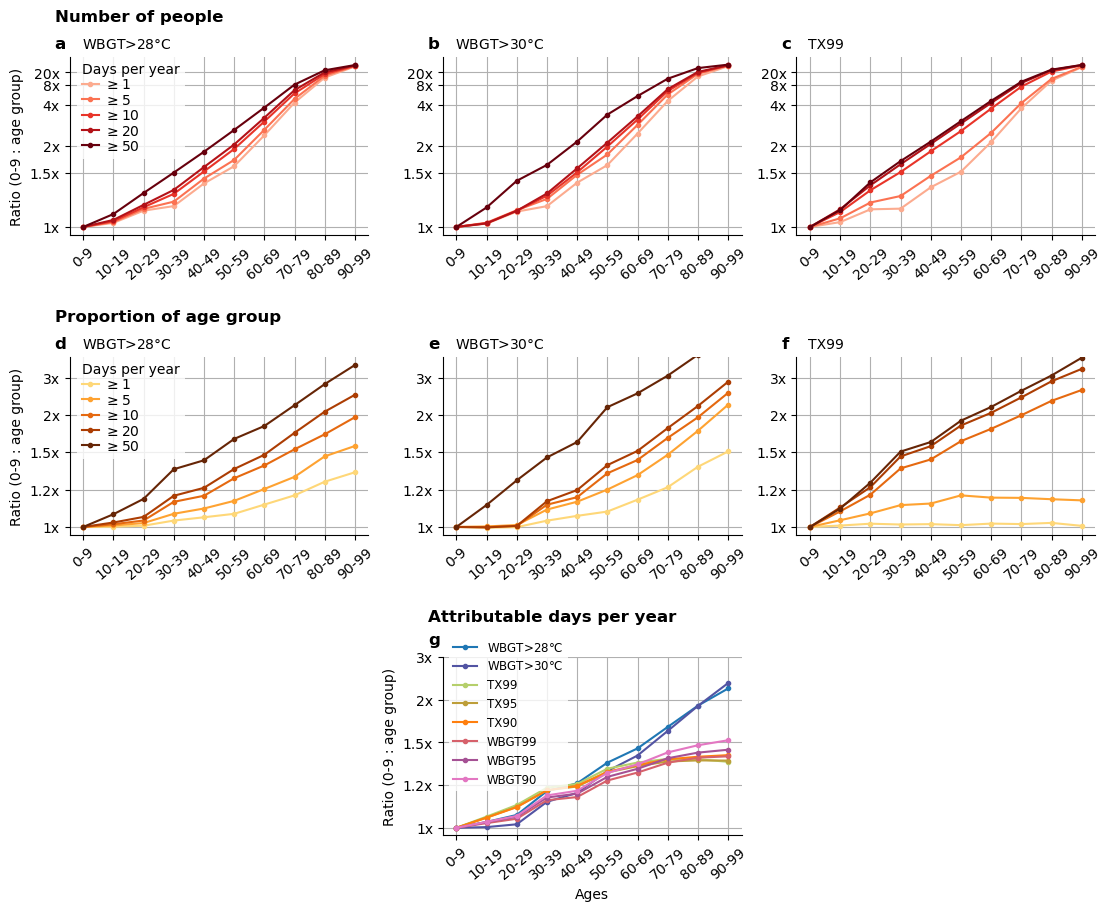

In [41]:

fig = plt.figure(figsize=(11, 9), layout='constrained', facecolor='none')

gs = fig.add_gridspec(3, 3)

# List of subplot grid positions
subplot_positions = [
    [(0, 0), (0, 1), (0, 2)],  # First row
    [(1, 0), (1, 1), (1, 2)],  # Second row
    [(2, 1)]                    # Third row
]


# Create subplots and share y-axis within each row
axes = []
for i, row in enumerate(subplot_positions):
    row_axes = [fig.add_subplot(gs[r, c], sharey=axes[r*3] if axes and r<1 else None) for r, c in row];
    axes.extend(row_axes);



# row 1 

das=[da_n_people_ndays_obs, da_n_people_ndays_obs_30, da_n_people_ndays_obs_TX99]
titles=['a', 'b', 'c']
titles2=['WBGT>28$\degree$C', 'WBGT>30$\degree$C', 'TX99']
legends=[True, False, False]
custom_ticks = [1/1,  1/1.5, 1/2,  1/4, 1/8, 1/20]
cmap = 'Reds'
axes[0].annotate('Number of people', xy=(-.05, 1.2), xycoords='axes fraction', fontsize=12, fontweight='bold')


i=0
for da, title, title2, ax, leg in zip(das, titles, titles2, axes[0:3], legends):
    plot_normalized_slopes(da, ax, legend=leg, title=title, custom_ticks=custom_ticks, step_ages=9, x_hot_days=[1,5,10,20,50],cmap=cmap)
    ax.text(0.04,1.05,title2,transform=ax.transAxes)
    if i==0:
        ax.set_ylabel('Ratio (0-9 : age group)')
    i=+1





# row 2 

das=[da_prop_people_ndays_obs, da_prop_people_ndays_obs_30, da_prop_people_ndays_obs_TX99]
custom_ticks = [1/1,  1/1.2, 1/1.5, 1/2,  1/3]
titles=['d', 'e', 'f']
cmap = 'YlOrBr'
axes[3].annotate('Proportion of age group', xy=(-.05, 1.2), xycoords='axes fraction', fontsize=12, fontweight='bold')


i=0
for da, title, title2, ax, leg in zip(das, titles, titles2, axes[3:6], legends):
    plot_normalized_slopes(da, ax, legend=leg, title=title, custom_ticks=custom_ticks, step_ages=9, x_hot_days=[1,5,10,20,50],cmap=cmap)
    ax.text(0.04,1.05,title2,transform=ax.transAxes)
    if i==0:
        ax.set_ylabel('Ratio (0-9 : age group)')
    i=+1





# row3


das=[da_nAHD_percapita_peopledays_10y_obs, da_nAHD_percapita_peopledays_10y_obs_30,
     da_nAHD_percapita_peopledays_10y_obs_TX99, da_nAHD_percapita_peopledays_10y_obs_TX95, da_nAHD_percapita_peopledays_10y_obs_TX90, 
     da_nAHD_percapita_peopledays_10y_obs_W99, da_nAHD_percapita_peopledays_10y_obs_W95, da_nAHD_percapita_peopledays_10y_obs_W90]
labels =['WBGT>28$\degree$C', 'WBGT>30$\degree$C', 
         'TX99', 'TX95', 'TX90', 
        'WBGT99', 'WBGT95', 'WBGT90']
title = 'g'
cmap = custom_cmap
axes[6].annotate('Attributable days per year', xy=(-.05, 1.2), xycoords='axes fraction', fontsize=12, fontweight='bold')


ax=axes[-1]
plot_normalized_slopes_percap(das, ax, title=title, custom_ticks=custom_ticks, step_ages=9, labels=labels, cmap=cmap)
ax.set_ylabel('Ratio (0-9 : age group)')



# Scale y axes to match
[axes[i].set_ylim(axes[j].get_ylim()) for i,j in [(1,0),(2,0),(4,3),(5,3)]];


# spine visibility 
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Save
# plt.savefig(os.path.join(figdir, 'fig2_SI_slopes_reanalysis_median.png'), dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(figdir, 'fig2_SI_slopes_reanalysis_median.pdf'), dpi=300, bbox_inches='tight', transparent=True)


# Reporting numbers

In [49]:
da = da_n_people_ndays_obs #WBGT28
( da.sel(age_ranges=0) / da ).astype(float).median(dim='model').to_pandas().round(1) #- 1

# additional % 


age_ranges,0,10,20,30,40,50,60,70,80,90
features,,,,,,,,,,
n_atleast_1,1.0,1.0,1.1,1.1,1.4,1.6,2.3,4.2,12.2,72.5
n_atleast_5,1.0,1.0,1.1,1.2,1.4,1.7,2.5,4.7,14.2,85.9
n_atleast_10,1.0,1.0,1.1,1.3,1.5,1.9,2.8,5.6,16.6,107.5
n_atleast_20,1.0,1.0,1.2,1.3,1.6,2.0,3.0,6.3,20.0,133.8
n_atleast_50,1.0,1.1,1.3,1.5,1.9,2.5,3.8,8.0,26.9,198.0


In [67]:
da = da_nAHD_percapita_peopledays_10y_obs.sel(features='per_capita_days')

(da.sel(age_ranges=0) - da).median(dim='model').to_pandas().round(0)

age_ranges
0      0.0
10     1.0
20     2.0
30     4.0
40     5.0
50     7.0
60     8.0
70    10.0
80    13.0
90    14.0
dtype: float64

In [68]:
(da.median(dim='model').to_pandas()[0] - da.median(dim='model').to_pandas()).round(0)

age_ranges
0      0.0
10     1.0
20     2.0
30     5.0
40     7.0
50     9.0
60    10.0
70    13.0
80    15.0
90    18.0
dtype: float64